In [ ]:
#This code computes medians of errors and uses bootstrapping to calculate errors of medians

In [48]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import bootstrap
sns.set_theme(context='paper', style='white', font="Helvetica", font_scale=1, color_codes=True, rc=None)
sns.set_style("ticks")

In [49]:
#Get errors from approximation
def get_errors(resolution):
    #read errors
    errors_approximation=pd.read_csv('../data/'+ 'all_errors_' + resolution +  '.csv',index_col=0)
    columns=["sigma", "function","rmse_nn_train", "rmse_nn_test", "rmse_mdl_train", "rmse_mdl_test", "n", "r"]
    errors_approximation=errors_approximation[columns]

    #divide between train/test
    errors_approximation_train=errors_approximation[["sigma","function", "rmse_nn_train", "rmse_mdl_train","n", "r"]]
    errors_approximation_train=pd.melt(errors_approximation_train,id_vars=["sigma","function", "n", "r"], var_name="error_train",value_name= "value_train")   

    errors_approximation_test=errors_approximation[["sigma","function", "rmse_nn_test", "rmse_mdl_test","n", "r"]]
    errors_approximation_test=pd.melt(errors_approximation_test,id_vars= ["sigma","function", "n", "r"], var_name="error_test", value_name= "value_test")

    #Separate tanh and leaky ReLU
    errors_tanh_train=errors_approximation_train[errors_approximation_train['function']=='tanh']
    errors_tanh_test=errors_approximation_test[errors_approximation_test['function']=='tanh']

    errors_leaky_train=errors_approximation_train[errors_approximation_train['function']=='leaky_ReLU']
    errors_leaky_test=errors_approximation_test[errors_approximation_test['function']=='leaky_ReLU']

    return errors_tanh_train, errors_tanh_test, errors_leaky_train, errors_leaky_test


In [50]:

resolutions=['1x', '2x', '4e-3x']

# Initialize combined DataFrames
combined_tanh_train = pd.DataFrame()
combined_tanh_test = pd.DataFrame()
combined_leaky_train = pd.DataFrame()
combined_leaky_test = pd.DataFrame()

# Load and combine data for each resolution
for resolution in resolutions:
    errors_tanh_train, errors_tanh_test, errors_leaky_train, errors_leaky_test = get_errors(resolution)
    
    # Add resolution identifier
    errors_tanh_train['resolution'] = resolution
    errors_tanh_test['resolution'] = resolution
    errors_leaky_train['resolution'] = resolution
    errors_leaky_test['resolution'] = resolution
    
    # Combine DataFrames
    combined_tanh_train = pd.concat([combined_tanh_train, errors_tanh_train])
    combined_tanh_test = pd.concat([combined_tanh_test, errors_tanh_test])
    combined_leaky_train = pd.concat([combined_leaky_train, errors_leaky_train])
    combined_leaky_test = pd.concat([combined_leaky_test, errors_leaky_test])

display(combined_tanh_train)

,sigma,function,n,r,error_train,value_train,resolution
330,0.0,tanh,0,0,rmse_nn_train,0.012567,1x
331,0.0,tanh,1,0,rmse_nn_train,0.012049,1x
332,0.0,tanh,2,0,rmse_nn_train,0.007093,1x
333,0.0,tanh,3,0,rmse_nn_train,0.001443,1x
334,0.0,tanh,4,0,rmse_nn_train,0.002433,1x
...,...,...,...,...,...,...,...
1315,0.2,tanh,5,2,rmse_mdl_train,0.037562,4e-3x
1316,0.2,tanh,6,2,rmse_mdl_train,0.034651,4e-3x
1317,0.2,tanh,7,2,rmse_mdl_train,0.019436,4e-3x
1318,0.2,tanh,8,2,rmse_mdl_train,0.022791,4e-3x


In [51]:
#Figure configuration
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 16*cm; height=16*cm
#width = 8*cm; height=6*cm

#colors from seaborn's colorblind palette
color_data=sns.color_palette("colorblind")[0]
color_noise=sns.color_palette("colorblind")[7]
color_ann=sns.color_palette("colorblind")[4]
color_bms=sns.color_palette("colorblind")[2]

colors={'4e-3x':['#fee0d2', '#deebf7'],
       '2x':['#fc9272', '#9ecae1'],
       '1x':['#de2d26', '#3182bd'] }

#Fonts and sizes                                                                                    
size_axis=14;size_ticks=12;size_title=5
line_w=1; m_size=8 #width and marker size                                                          
markers = {'rmse_nn_train': 'o', 'rmse_mdl_train': 's'} 

output_path='../results/'

resamples=100000; bs_seed=1111
ymin=1e-4;ymax=0.75

6.299212598425196 6.299212598425196
[6.2992126 6.2992126]


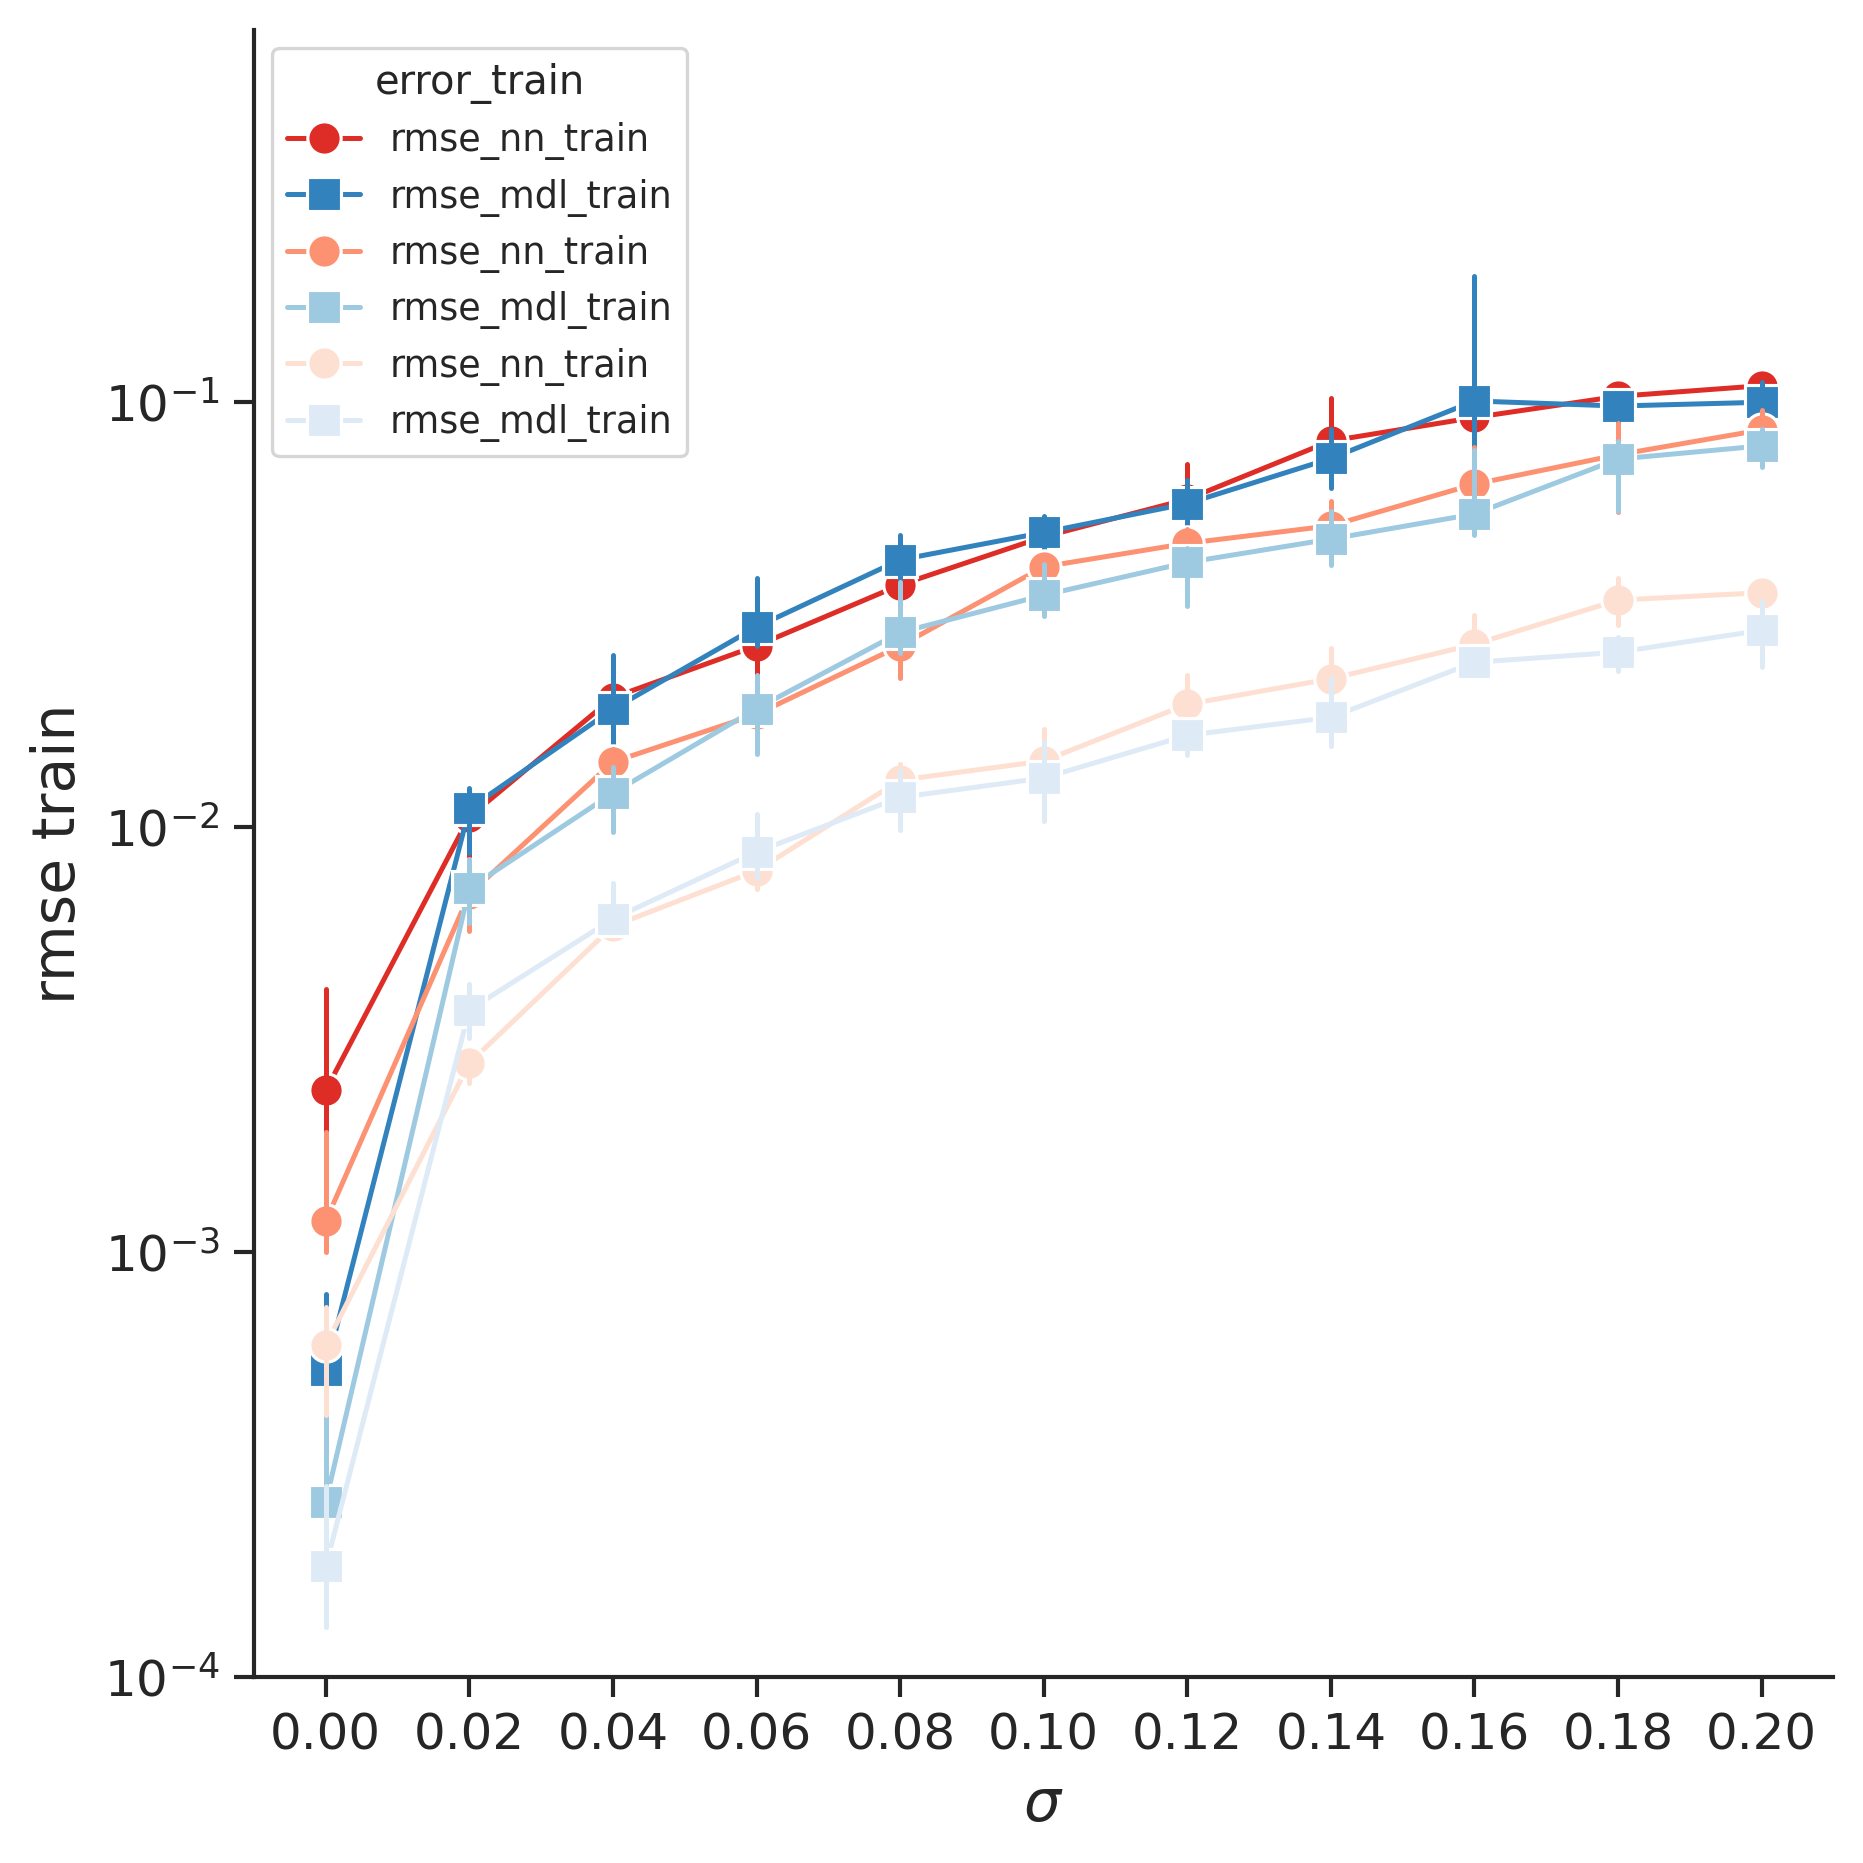

In [52]:
#Plot tanh approximations

#tanh - rmse train
fig=figure(figsize=(width,height), dpi=300)
print(width, height)

for resolution in resolutions:
    data = combined_tanh_train[combined_tanh_train['resolution'] == resolution]
    sns.lineplot(
        data=data, x='sigma', y='value_train', hue='error_train', style='error_train',
        estimator='median', err_style="bars", errorbar=('ci', 95), n_boot=resamples, seed=bs_seed,
        markers=[markers['rmse_nn_train'], markers['rmse_mdl_train']], dashes=False, markersize=m_size, legend="full", 
        palette=colors[resolution])

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse train',fontsize=size_axis)
plt.yscale("log")
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
xtick_labels=np.arange(0.0,0.22,0.02)
plt.xticks(xtick_labels, fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.minorticks_off()
plt.ylim(ymin,ymax)

sns.despine()
plt.tight_layout()

name_fig='all_approximation_medians_tanh_paper' 
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)
size = fig.get_size_inches()
print(size)
#------------------------------------------------------------------------------------------------------------------------

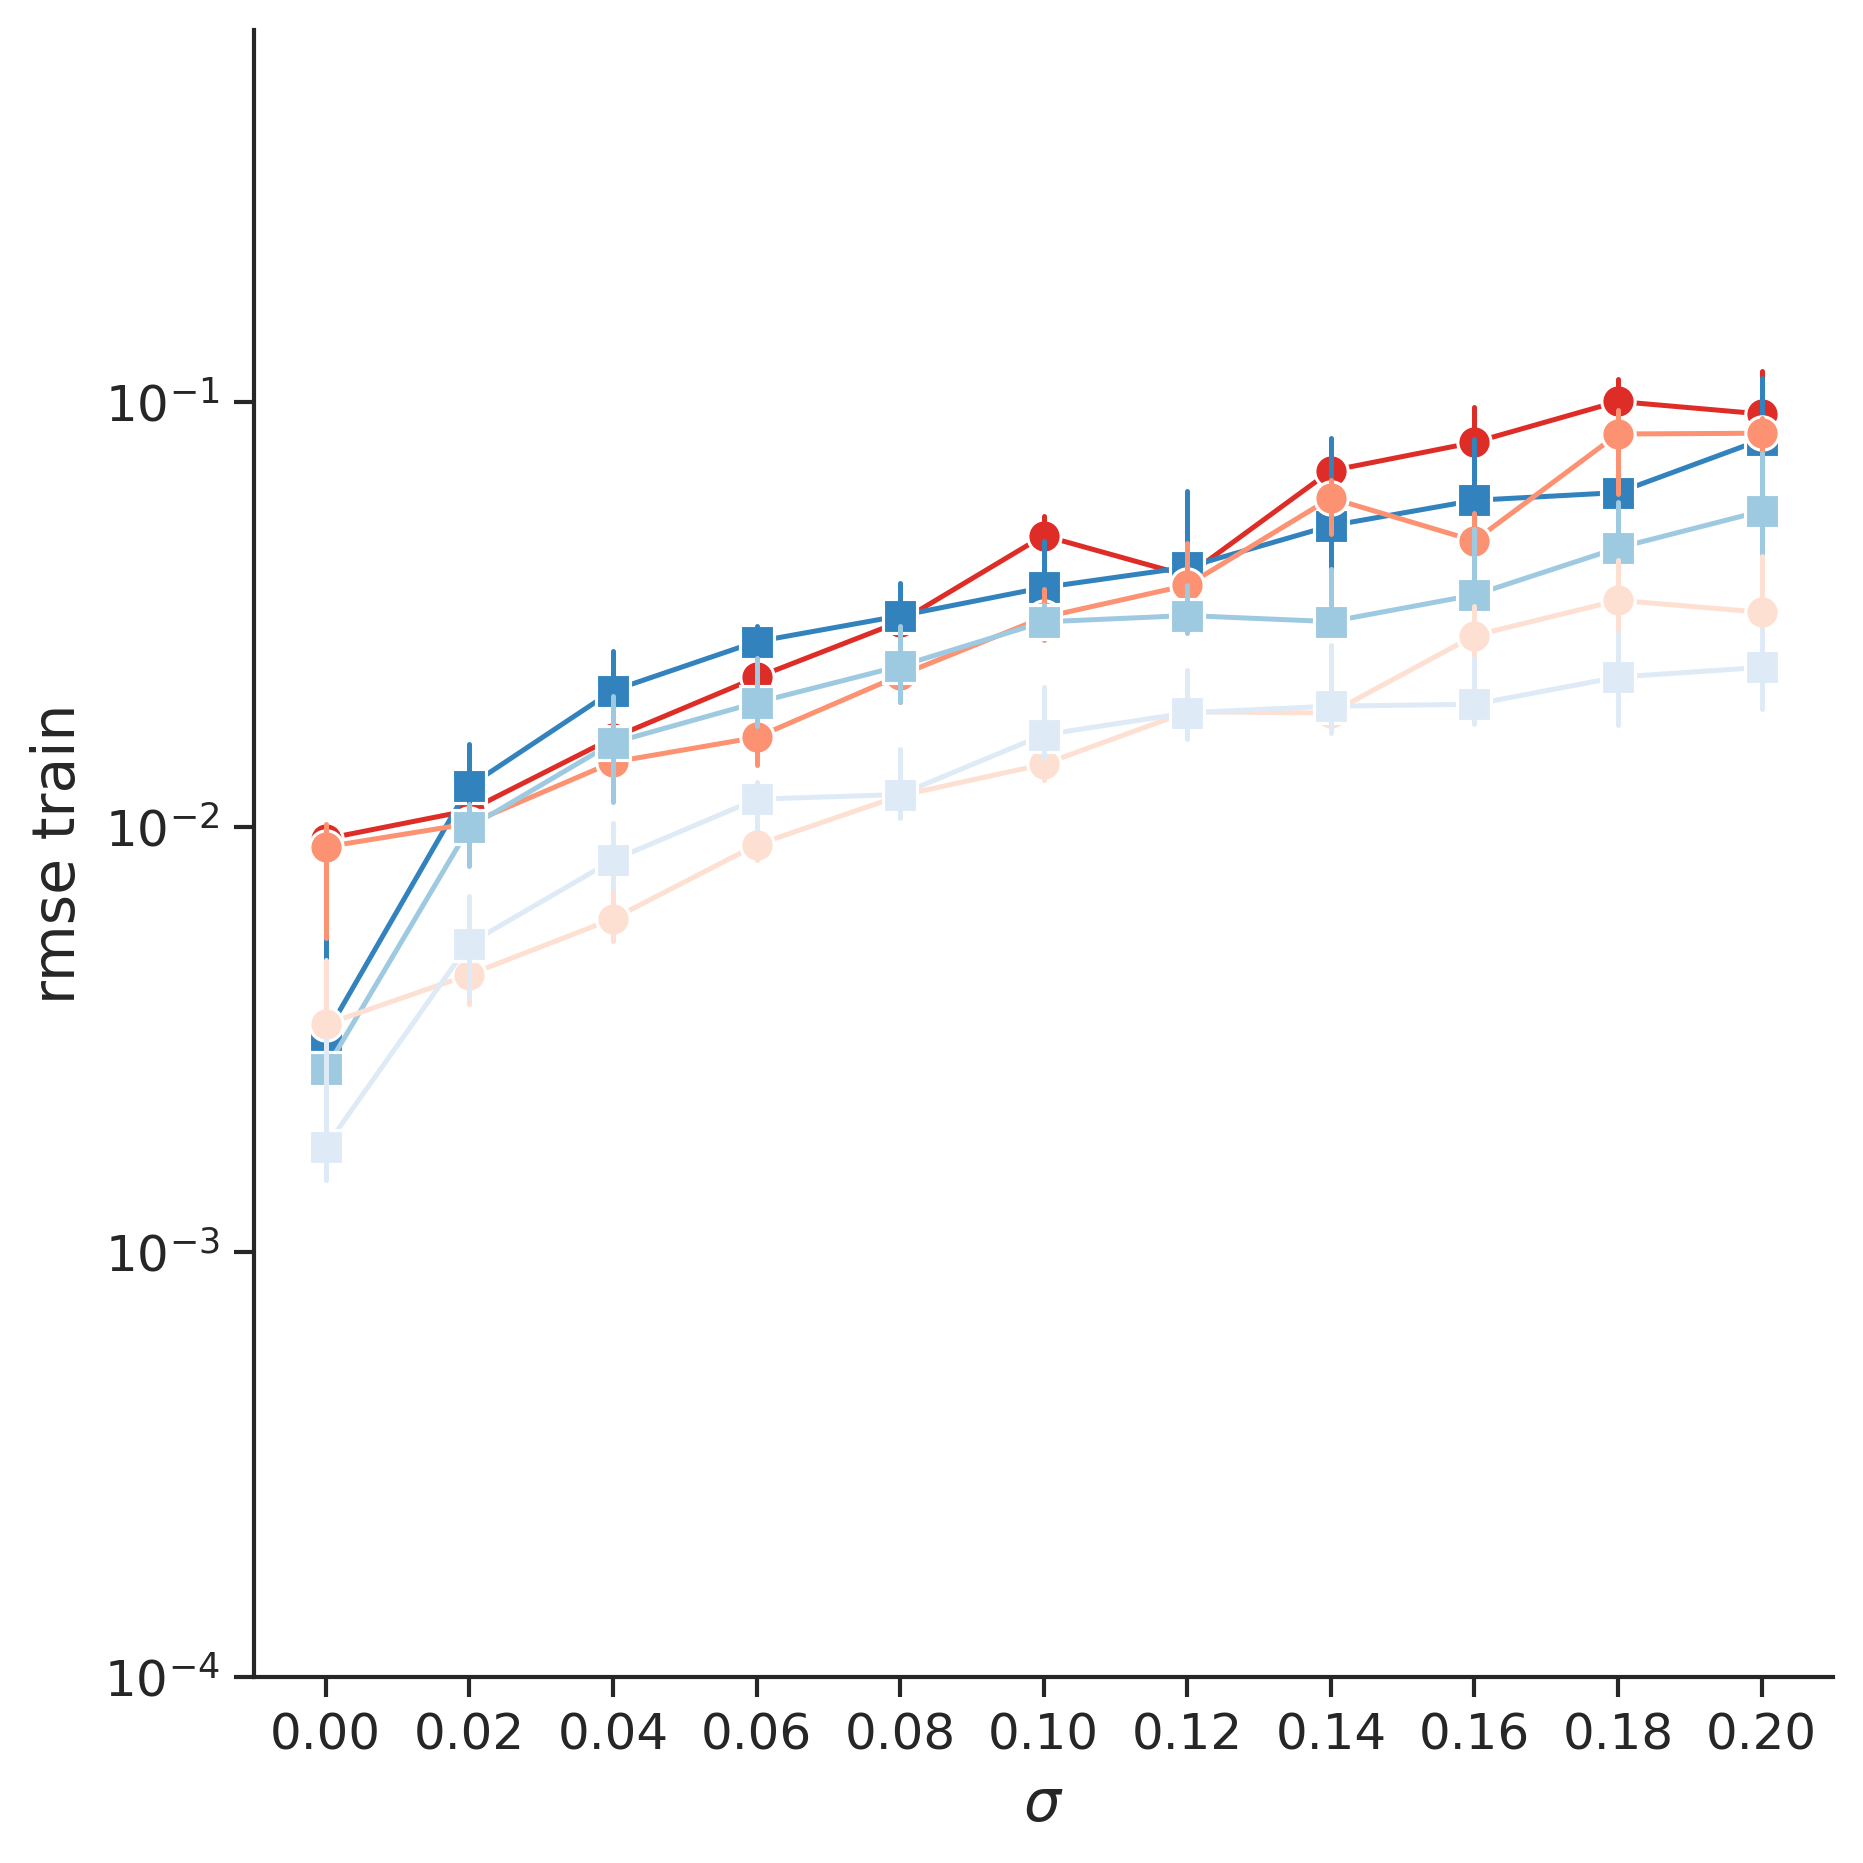

In [53]:
#Plot leaky approximations

#tanh - rmse train
fig=figure(figsize=(width,height), dpi=300)

for resolution in resolutions:
    data = combined_leaky_train[combined_leaky_train['resolution'] == resolution]
    sns.lineplot(
        data=data, x='sigma', y='value_train', hue='error_train', style='error_train',
        estimator='median', err_style="bars", errorbar=('ci', 95), n_boot=resamples, seed=bs_seed,
        markers=[markers['rmse_nn_train'], markers['rmse_mdl_train']], dashes=False, markersize=m_size, legend=False, 
        palette=colors[resolution])

#labels, limits, and ticks
plt.xlabel(r'$\sigma$',fontsize=size_axis);plt.ylabel('rmse train',fontsize=size_axis)
plt.yscale("log")
xtick_labels=np.arange(0.0,0.22,0.02)
plt.xticks(xtick_labels, fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.minorticks_off()

plt.ylim(ymin,ymax)
sns.despine()
plt.tight_layout()

name_fig='all_approximation_medians_leaky_paper' 
plt.savefig(output_path+name_fig + '.svg',dpi=300)
plt.savefig(output_path+name_fig + '.png',dpi=300)

#------------------------------------------------------------------------------------------------------------------------